In [1]:
#Implementation of trb in rocketpy with notes about data: from where it was taken, if it is reliable and if not from where we want to take it in the future.

In [2]:
#Imports
from rocketpy import Rocket, Environment, Flight, LiquidMotor, Fluid, CylindricalTank, MassFlowRateBasedTank
from math import exp
from datetime import datetime, timedelta
from rocketpy.simulation import FlightDataExporter

In [3]:
#Env
#Standard atmosphere - no wind for stable outcomes
env = Environment() # Using Standard Atmosphere by default

#Toruń Kod od Antka
# env = Environment(latitude=52.94401645806493, longitude=18.63890735729045)
# # 52.94401645806493, 18.63890735729045 toruń poligon <----
# moment = datetime.date.fromisoformat('2025-07-27')
# env.set_date((moment.year, moment.month, moment.day, 14))  # godizna w UTC (tam byla 15:51 GMT+2)
# env.set_atmospheric_model(type="Windy", file="GFS")
# env.max_expected_height = 10000


#Far-out
# tomorrow = datetime.now() + timedelta(days=1)
# env = Environment(
#     date=tomorrow,  
#     latitude=35.35,
#     longitude=-117.81, # Far-out not precise
# )
# env.set_elevation("Open-Elevation")
# env.set_atmospheric_model(type="forecast", file="GFS")
# env.max_expected_height = 10000
# env.plots.atmospheric_model()

#env.info()

In [4]:
#Change of mass as a time function: linear approximation using two linear functions

def mass_change(time):
    if time < 5:
        return 4.2
    else:
        return 0.62

In [5]:
liq_mix = Fluid(name="mix", density=1133.8)
gas_mix = Fluid(name="mix", density=1.8)

tank_shape = CylindricalTank(radius=0.093, height=1.08, spherical_caps=False)

mix_tank = MassFlowRateBasedTank(   
    name="mix_tank",
    geometry=tank_shape,
    flux_time=11.2,
    initial_liquid_mass=25,
    initial_gas_mass=0.0001,
    liquid_mass_flow_rate_in=0,
    liquid_mass_flow_rate_out=lambda t: mass_change(t),
    gas_mass_flow_rate_in=0,
    gas_mass_flow_rate_out=lambda t: 0.0001 / 11.2 * exp(-0.25 * t),
    liquid=liq_mix,
    gas=gas_mix,


)

Nozzle Details
Nozzle Radius: 0.036 m

Motor Details
Total Burning Time: 14.4 s
Total Propellant Mass: 25.000 kg
Structural Mass Ratio: 0.097
Average Propellant Exhaust Velocity: 2028.507 m/s
Average Thrust: 2240.935 N
Maximum Thrust: 4575.401 N at 1.089 s after ignition.
Total Impulse: 32269.462 Ns



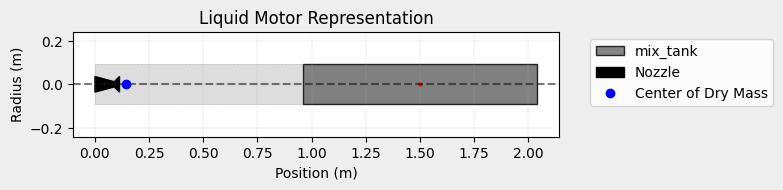

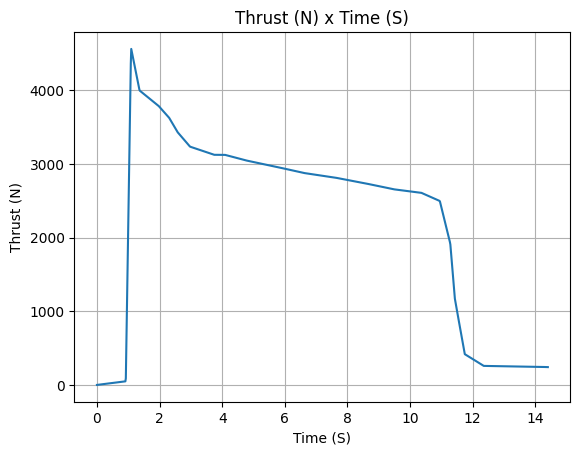

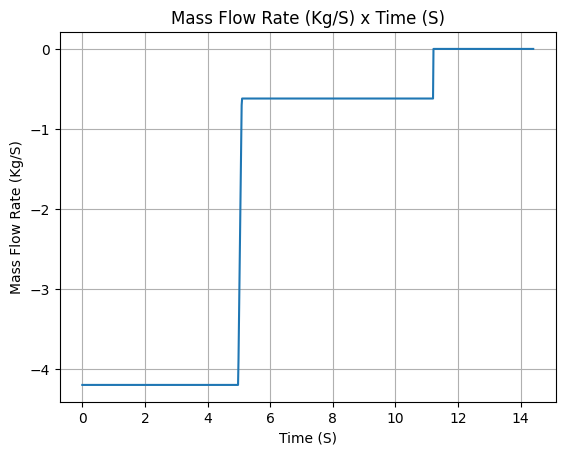

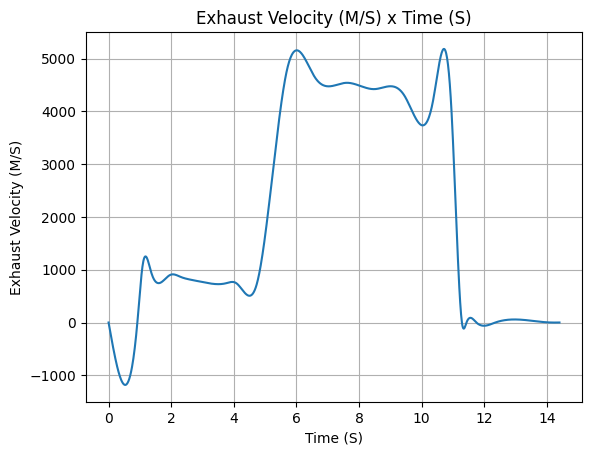

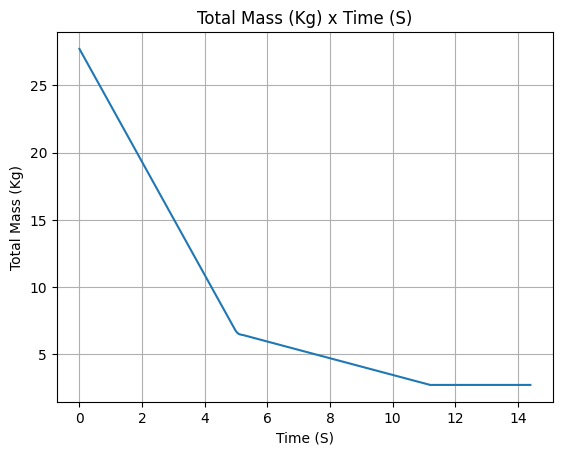

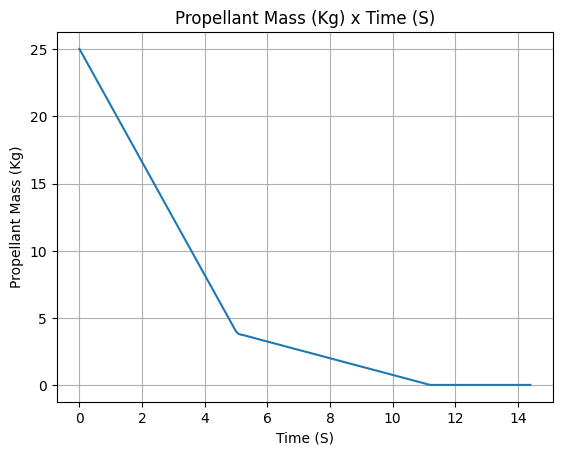

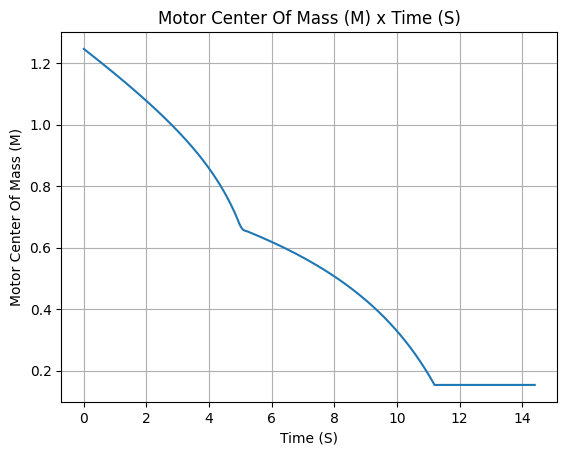

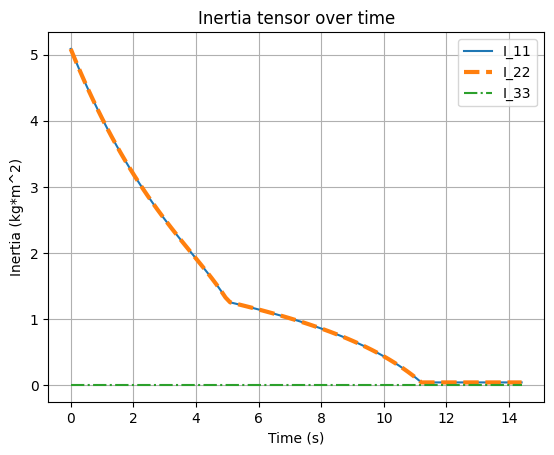

In [6]:
# Motor
# Thrust source from openrocket .eng file, dry mass it the mass of a motor: 2.7
z4000 = LiquidMotor(
    thrust_source=".\\data\\AGH-SS_Z4000-10sBurn-optimal.eng", #From tests
    dry_mass=2.7,
    dry_inertia=(0.02143, 0.02143, 0.005535), #This should be calculated using CAD, here I use estimations
    nozzle_radius=0.036, #From technical report
    center_of_dry_mass_position=0.144, #Estimated from openrocket
    nozzle_position=0,
    burn_time=14.4,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)
z4000.add_tank(tank=mix_tank, position=1.5) #From nozzle to center of the tank


z4000.all_info()

In [7]:
# Rocket 
trb = Rocket(
    radius=0.1,
    mass=58.367, #All mass - engine mass and fuel
    inertia=(98.203, 98.203, 0.29184), #Rough estimations, the correct values should be calculated from CAD
    power_off_drag=".\\data\\powerondrag.csv", #This should be taken from ansys or some other cfd simulation, here I use data from openrocket
    power_on_drag='.\\data\\powerondrag.csv',
    center_of_mass_without_motor=2.75, #from openrocket
    coordinate_system_orientation="nose_to_tail", #Same as in openrocket
)
trb.add_motor(z4000, position=4.49)
#trb.all_info()

In [8]:
#Aerodynamic surfaces taken from openrocket
nose_cone = trb.add_nose(
    length=0.7, kind="lvhaack", position=0
)

fin_set = trb.add_trapezoidal_fins(
    n=4,
    root_chord=0.287,
    tip_chord=0.059,
    span=0.202,
    sweep_length=0.228,
    position=4.21,
    cant_angle=0,
)

tail = trb.add_tail(
    top_radius=0.1, bottom_radius=0.065, length=0.287, position=4.21
)

rail_buttons = trb.set_rail_buttons(
    upper_button_position=2, #Just some value, not accurate
    lower_button_position=4, #Just some value, not accurate
    angular_position=45, #Just some value, not accurate
)
#Parachutes cd_s just guessed so that the velocity at the landing is similar to openrocket
# main = trb.add_parachute(
#     name="main",
#     cd_s=15, #Matched to openrocket impact velocity
#     trigger=1000,      # ejection altitude in meters
#     sampling_rate=105,
#     lag=0,
#     noise=(0, 8.3, 0.5),
#     radius=2.25, #From openrocket
#     height=2.25, #This should tell how flattened the parachute is, here it's perfect semi-sphere
#     porosity=0.0432,
# )

# drogue = trb.add_parachute(
#     name="drogue",
#     cd_s=1.45, #Matched to openrocket flight time
#     trigger="apogee",  # ejection at apogee
#     sampling_rate=105,
#     lag=1.5,
#     noise=(0, 8.3, 0.5),
#     radius=0.76, #From openrocket
#     height=0.76, #same as above
#     porosity=0.0432,
# )

main = trb.add_parachute(
    name='main',
    cd_s=0.8,
    radius=2.25,
    trigger=1000,
)
drogue = trb.add_parachute(
    name='drouge',
    cd_s=0.55,
    radius=0.85,
    trigger="apogee",
)
# trb.draw()
# trb.plots.drag_curves()


Inertia Details

Rocket Mass: 58.367 kg (without motor)
Rocket Dry Mass: 61.067 kg (with unloaded motor)
Rocket Loaded Mass: 86.067 kg
Rocket Structural Mass Ratio: 0.710
Rocket Inertia (with unloaded motor) 11: 104.798 kg*m2
Rocket Inertia (with unloaded motor) 22: 104.798 kg*m2
Rocket Inertia (with unloaded motor) 33: 0.297 kg*m2
Rocket Inertia (with unloaded motor) 12: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 13: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.000 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.1 m
Rocket Frontal Area: 0.031416 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.071 m
Rocket Center of Dry Mass - Nozzle Exit: 1.669 m
Rocket Center of Dry Mass - Center of Propellant Mass: 0.304 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.088 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 8.129/rad
Tail Lift Coefficient D

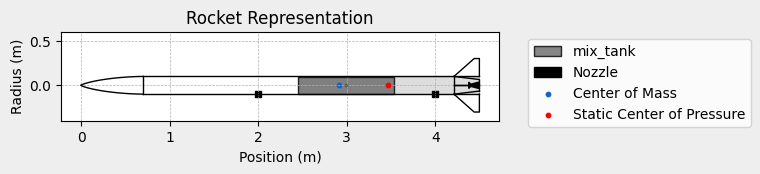


Mass Plots
----------------------------------------


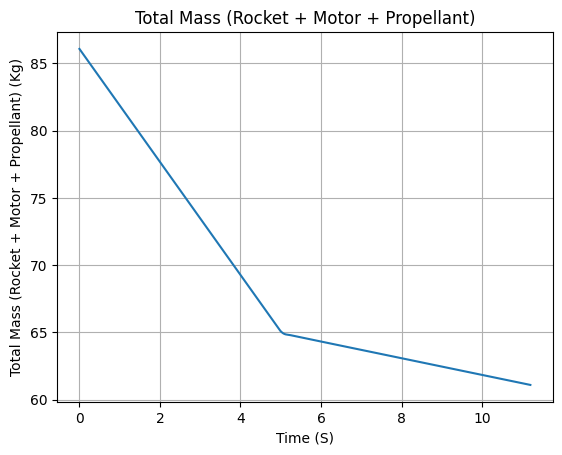

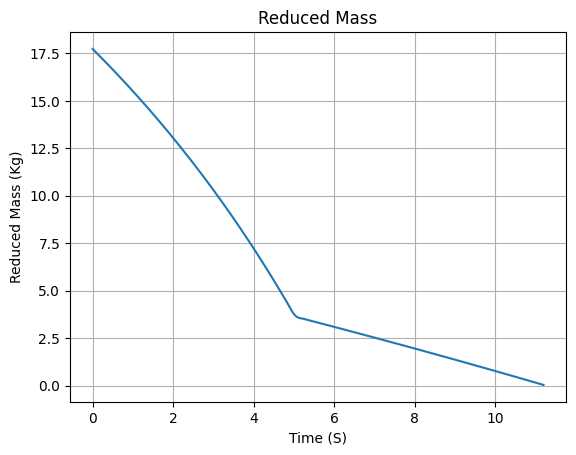


Aerodynamics Plots
----------------------------------------
Drag Plots
--------------------


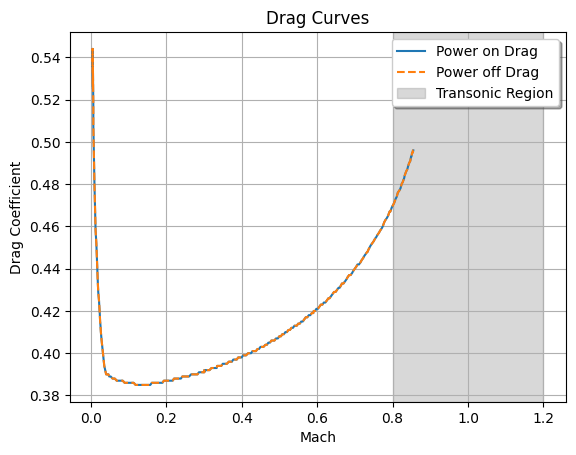


Stability Plots
--------------------


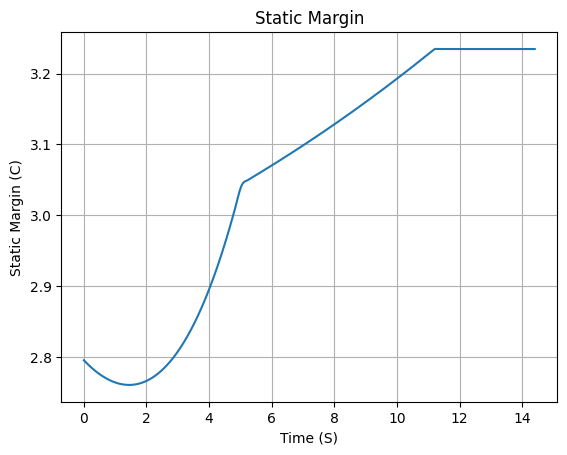

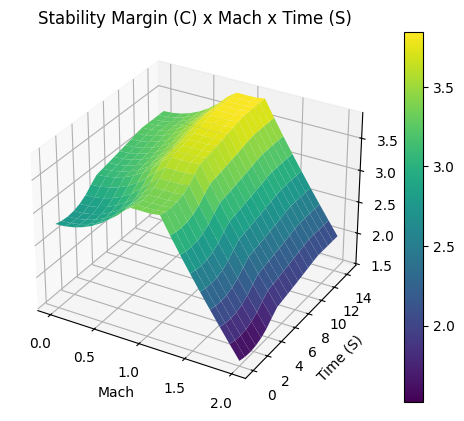


Thrust-to-Weight Plot
----------------------------------------


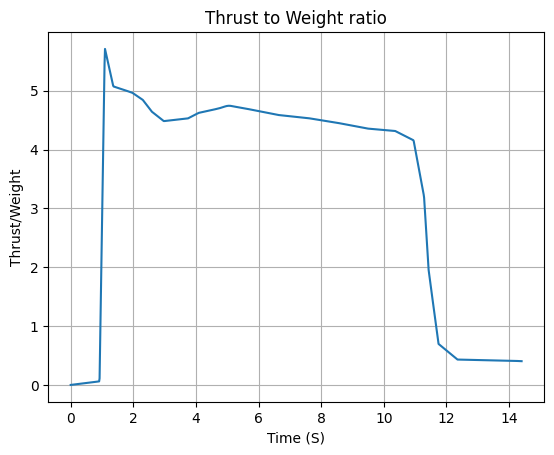


Initial Conditions

Initial time: 0.000 s
Position - x: 0.00 m | y: 0.00 m | z: 0.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude (quaternions) - e0: -0.923 | e1: 0.040 | e2: 0.017 | e3: 0.382
Euler Angles - Spin φ : 315.00° | Nutation θ: -5.00° | Precession ψ: 0.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s | ω3: 0.00 rad/s
Initial Stability Margin: 2.795 c


Surface Wind Conditions

Frontal Surface Wind Speed: 0.00 m/s
Lateral Surface Wind Speed: 0.00 m/s


Launch Rail

Launch Rail Length: 10 m
Launch Rail Inclination: 85.00°
Launch Rail Heading: 0.00°


Rail Departure State

Rail Departure Time: 1.605 s
Rail Departure Velocity: 24.689 m/s
Rail Departure Stability Margin: 2.765 c
Rail Departure Angle of Attack: -0.000°
Rail Departure Thrust-Weight Ratio: 5.030
Rail Departure Reynolds Number: 3.379e+05


Burn out State

Burn out time: 14.400 s
Altitude at burn out: 2661.587 m (ASL) | 2661.587 m (AGL)
Rocket speed at burn out: 267.381 m/s
Freestream veloci

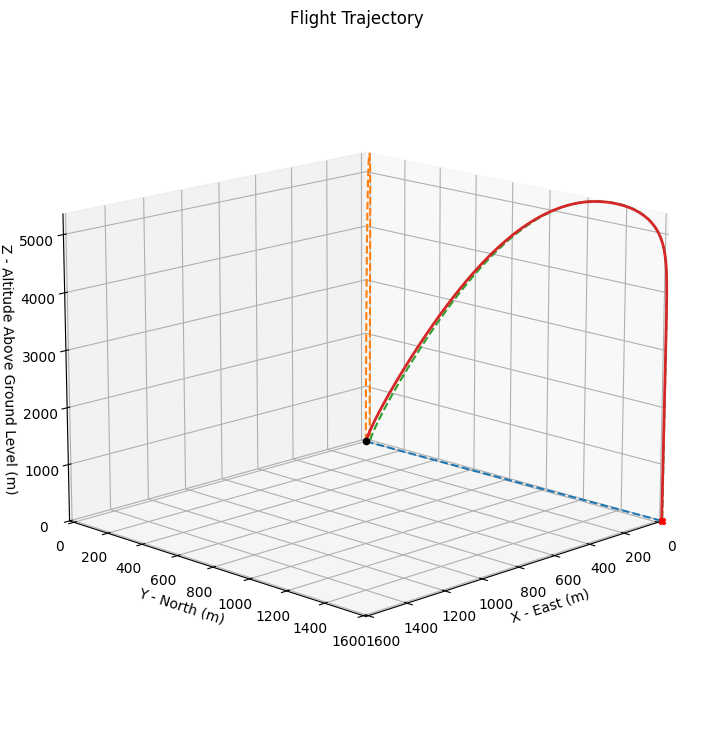



Trajectory Kinematic Plots



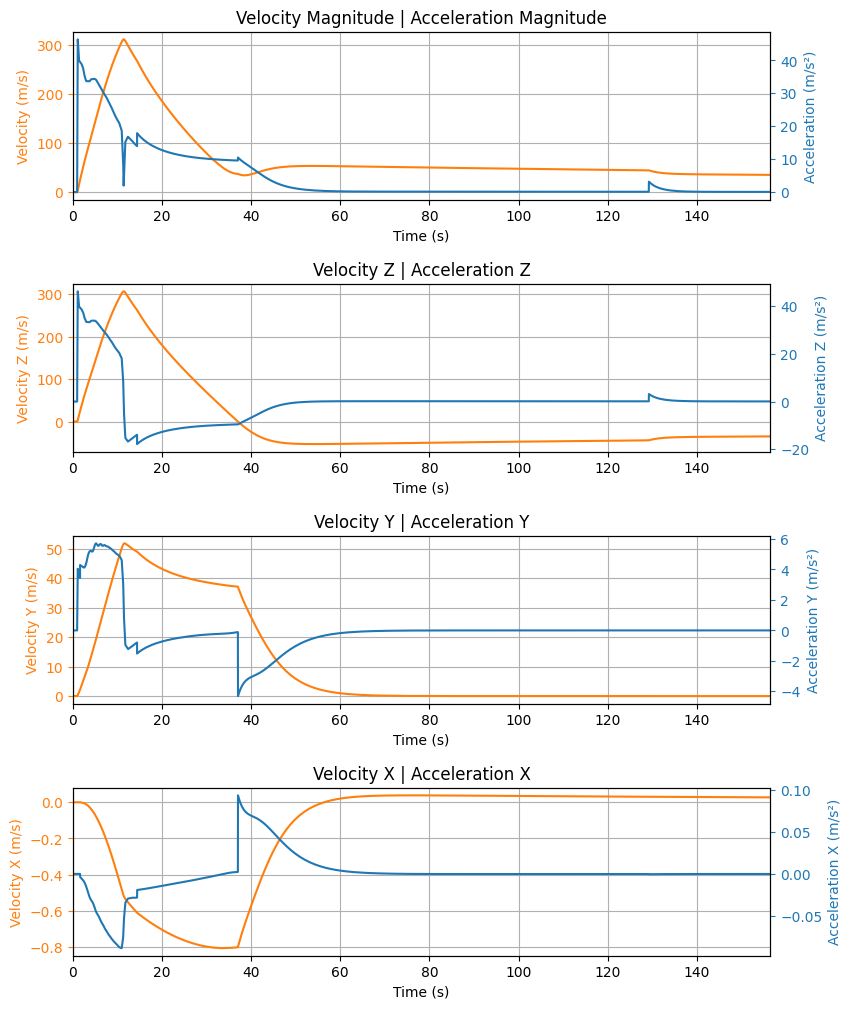



Angular Position Plots



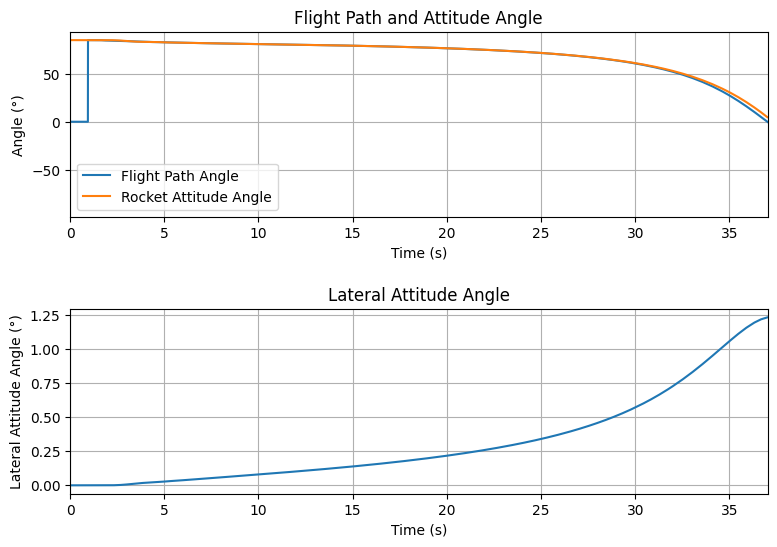



Path, Attitude and Lateral Attitude Angle plots



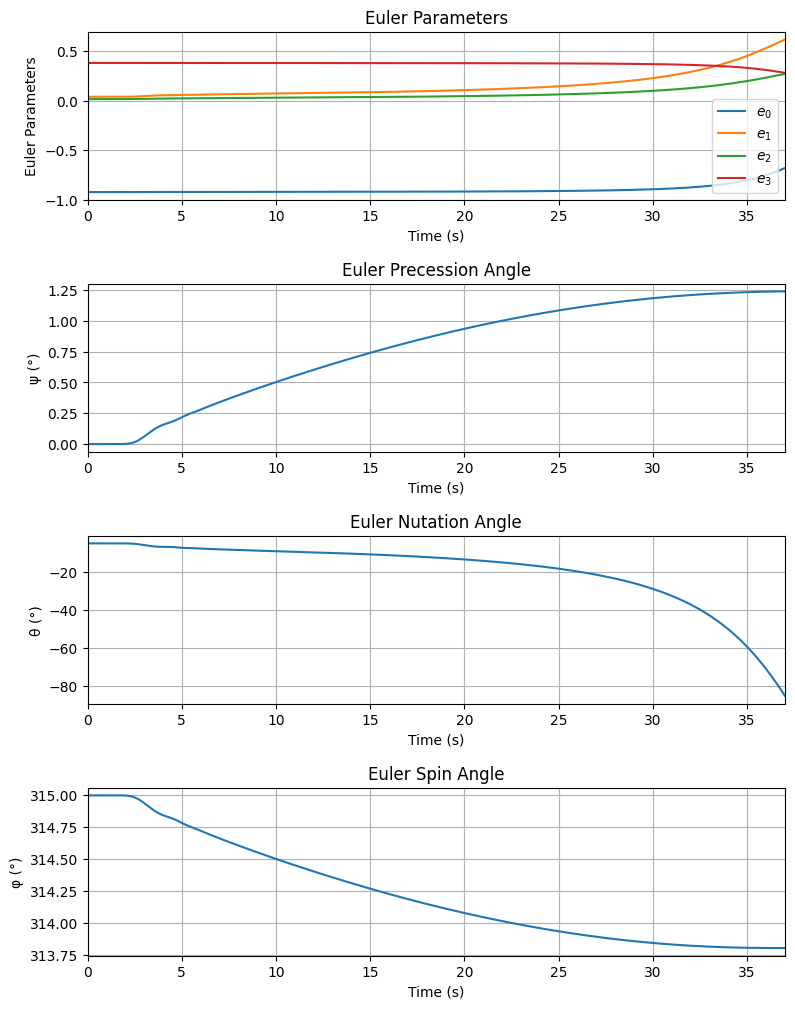



Trajectory Angular Velocity and Acceleration Plots



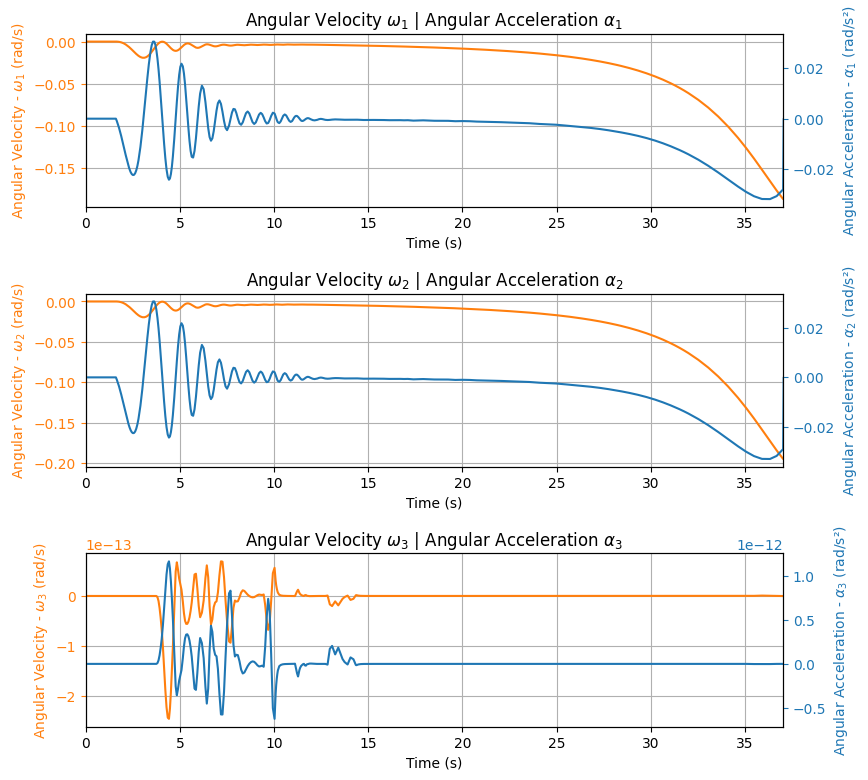



Aerodynamic Forces Plots



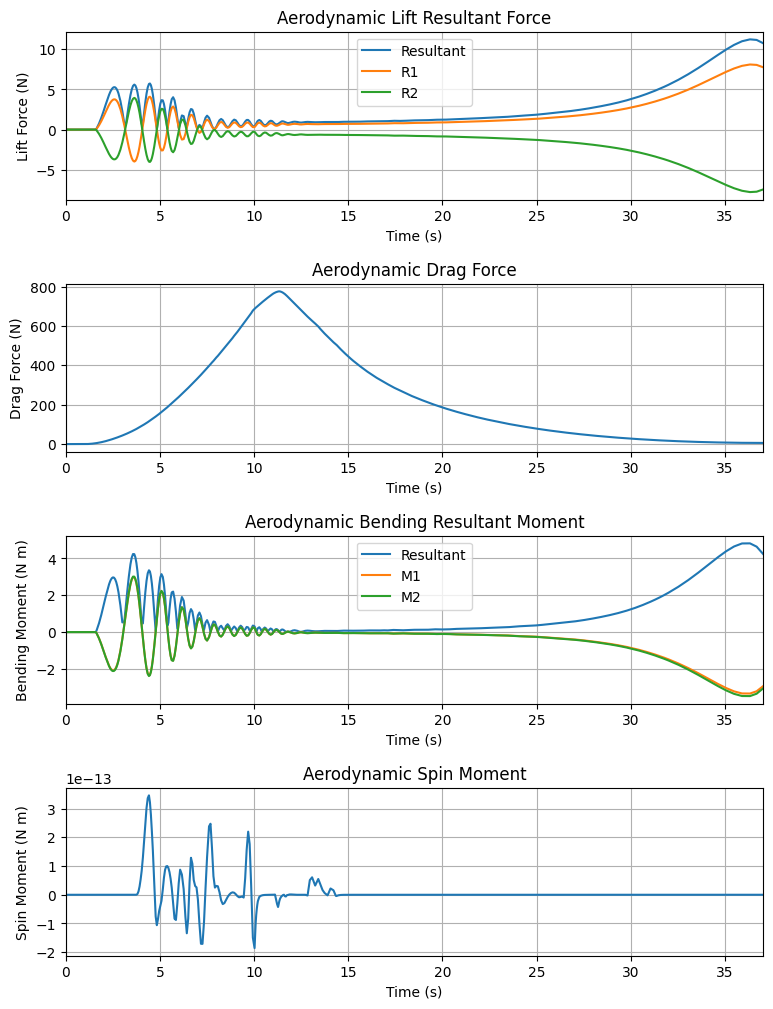



Rail Buttons Forces Plots



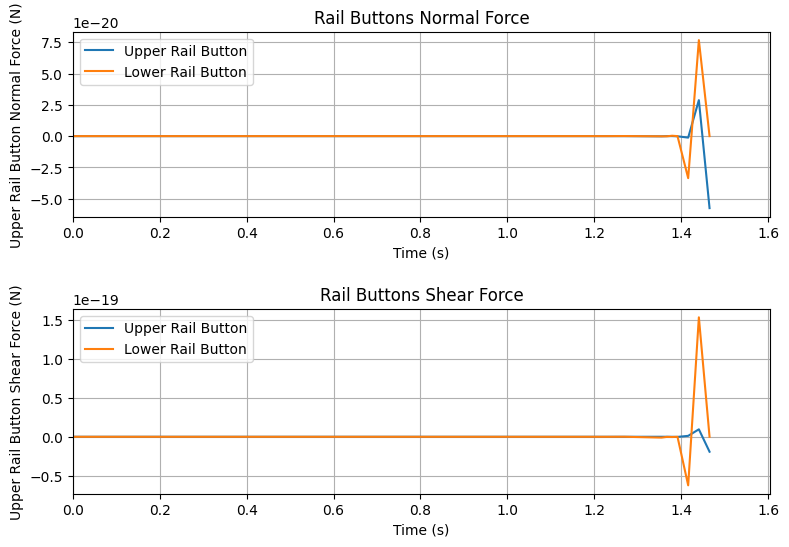



Trajectory Energy Plots



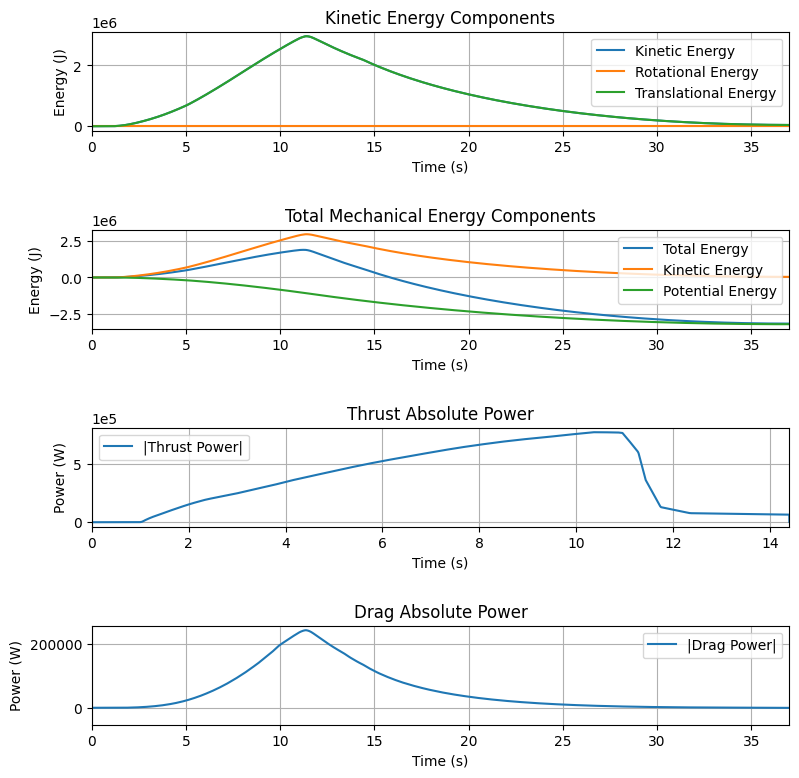



Trajectory Fluid Mechanics Plots



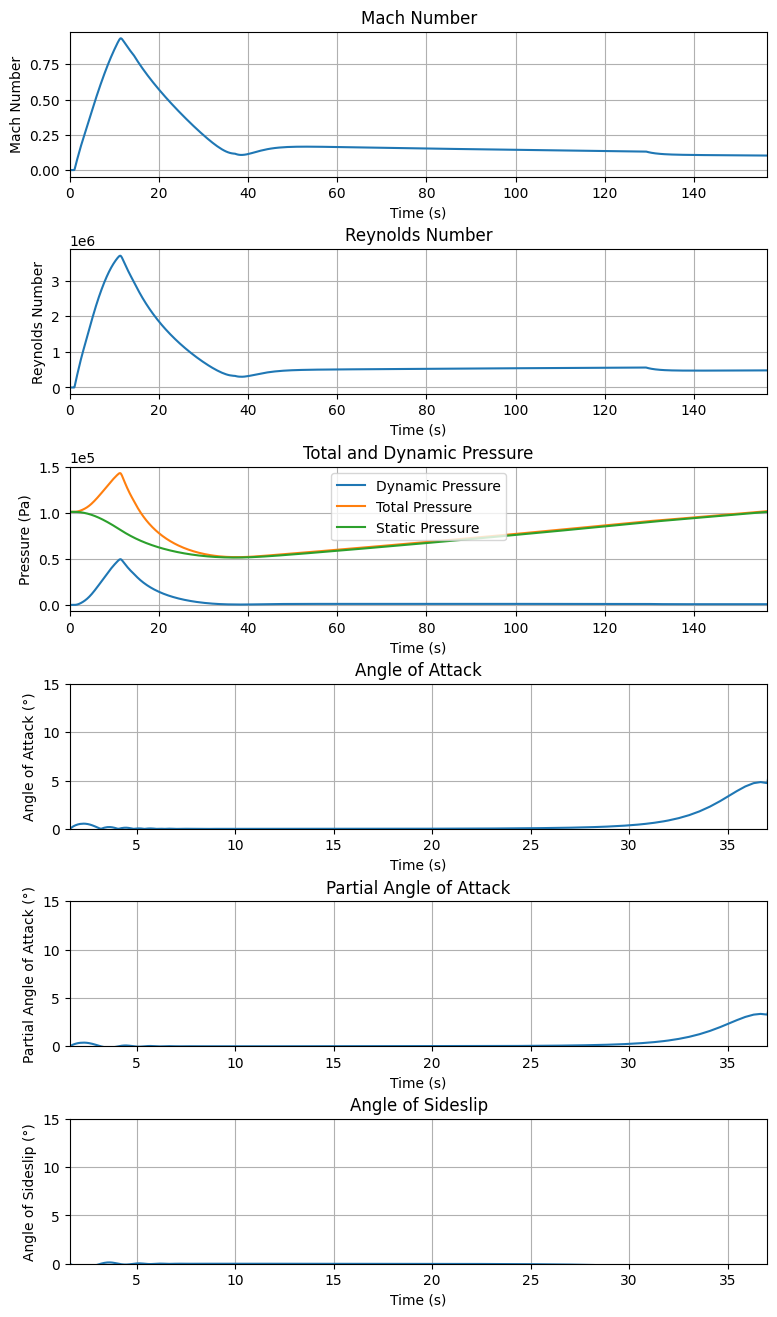



Trajectory Stability and Control Plots



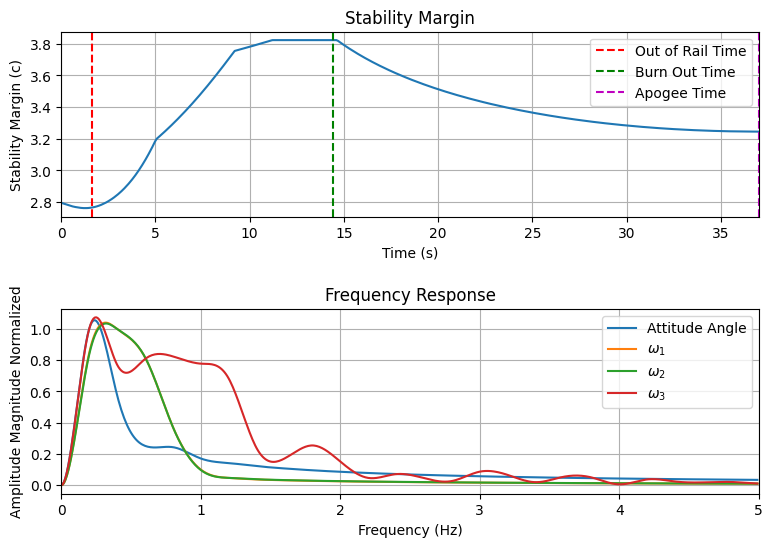



Rocket and Parachute Pressure Plots



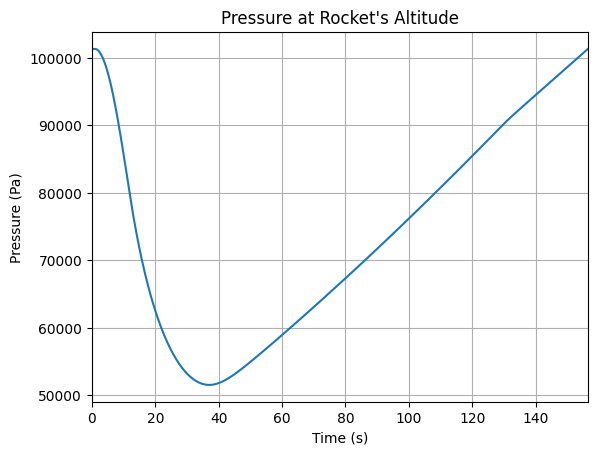


Parachute:  main


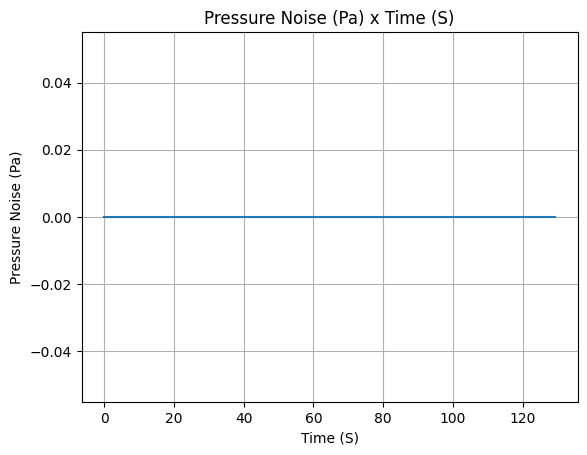

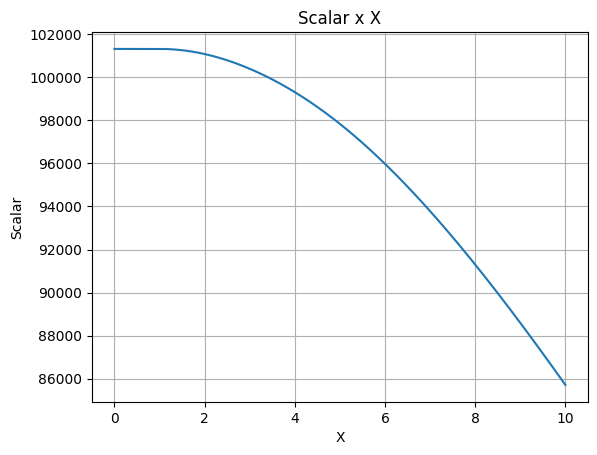

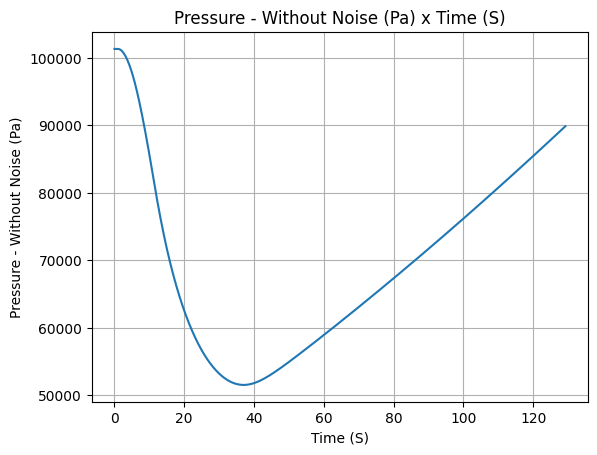


Parachute:  drouge


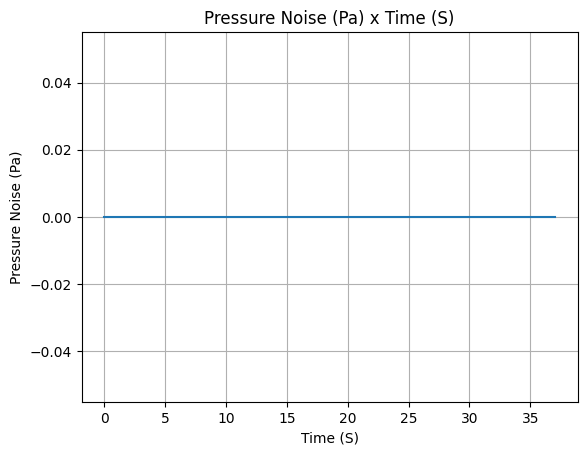

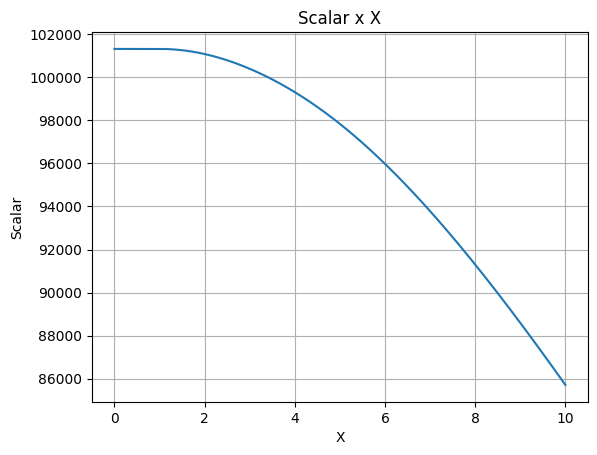

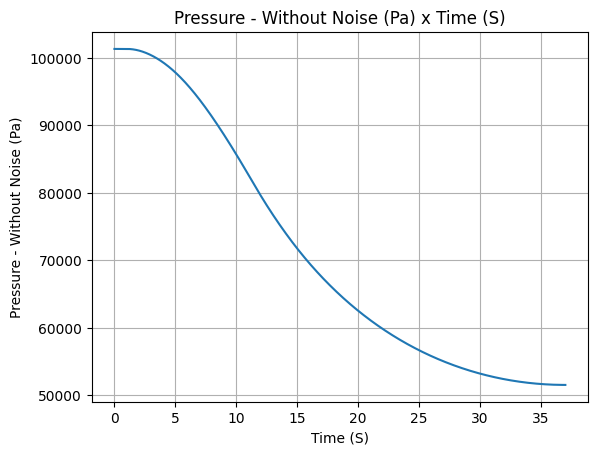

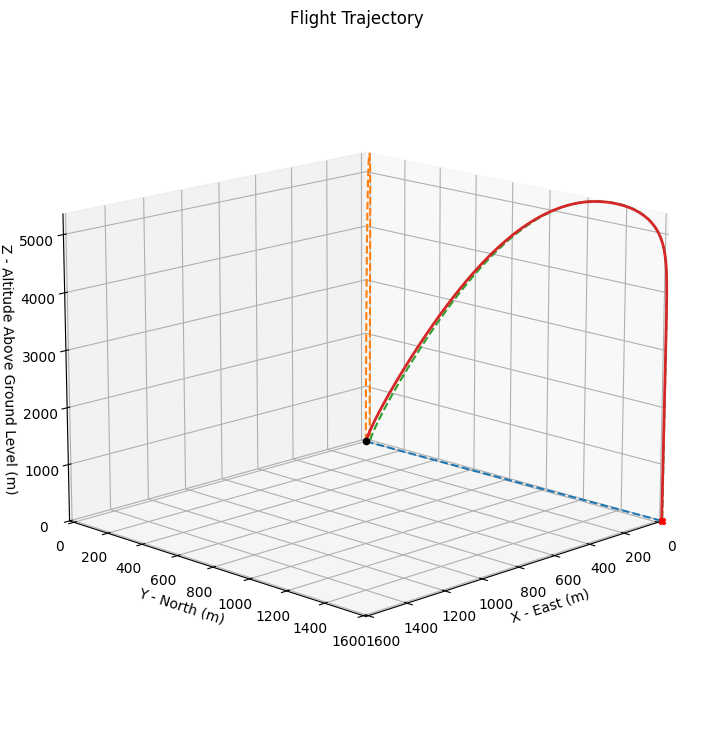


Impact Conditions

Time of impact: 156.523 s
X impact: -22.453 m
Y impact: 1612.891 m
Altitude impact: 0.000 m (ASL) | 0.000 m (AGL) 
Latitude: 0.0144888°
Longitude: -0.0002017°
Vertical velocity at impact: -35.066 m/s
Number of parachutes triggered until impact: 2


In [9]:
test_flight = Flight(
    rocket=trb, environment=env, rail_length=10, inclination=85, heading=0
    )

trb.all_info()
test_flight.all_info()
test_flight.plots.trajectory_3d()
#test_flight.plots.linear_kinematics_data()
test_flight.prints.impact_conditions()



In [10]:
#Exporting data from rocketpy
exporter = FlightDataExporter(test_flight)
exporter.export_data(
    "trb_flight_data.csv",
    "z", #Altitude
)

Columns found: Index(['# Time (s)', ' Z (m)'], dtype='object')
Plot saved as altitude_plot.png


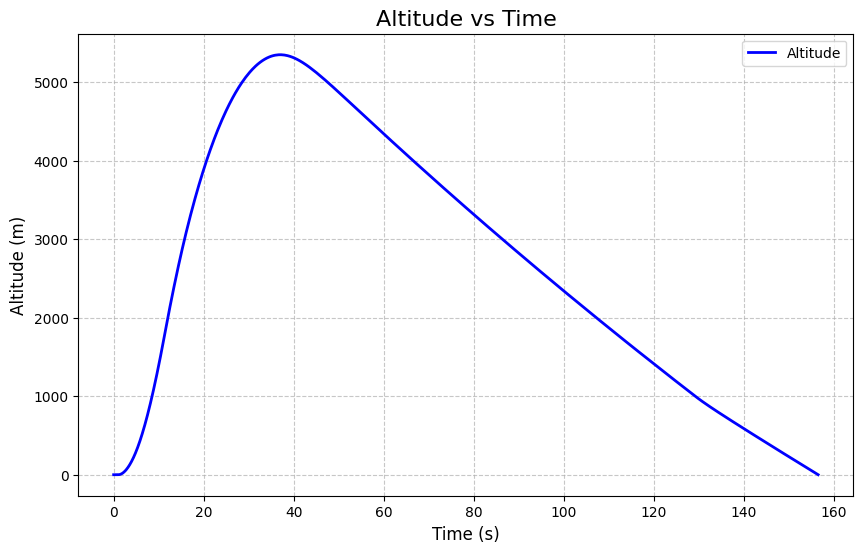

In [11]:
#Plotting custom plots
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the CSV file
# Replace 'trb_flight_data.csv' with the path to your file
csv_filename = 'trb_flight_data.csv'
df = pd.read_csv(csv_filename)

# 2. Inspect the column names (Optional: helps verify data is loaded correctly)
print("Columns found:", df.columns)

# 3. Plotting
plt.figure(figsize=(10, 6))

# NOTE: Change '# Time (s)' and ' Z (m)' below to match the exact headers in your CSV
x_column = '# Time (s)'
y_column = ' Z (m)'

plt.plot(df[x_column], df[y_column], label='Altitude', color='blue', linewidth=2)

# Labeling the graph
plt.title('Altitude vs Time', fontsize=16)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Altitude (m)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# 4. Save and Show the plot
plt.savefig('altitude_plot.png')
print("Plot saved as altitude_plot.png")